# Data Analysis Interview Challenge


## Part 1 ‑ Exploratory data analysis


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import r2_score
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold,cross_validate,GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import LinearRegression


from scipy.stats import t
from scipy import stats

from numpy.random import seed
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

In [2]:
#Import Data into dataframe
df = pd.read_json('logins.json')

In [3]:
#Display first 5 rows of df
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
#Total no. of rows in df
df.count()

login_time    93142
dtype: int64

In [5]:
#Check for null value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [6]:
#Data describe
df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [7]:
#Check for data's order
pd.Index(df.login_time).is_monotonic_increasing


False

In [8]:
#Check for data type
df.dtypes


login_time    datetime64[ns]
dtype: object

In [9]:
#Sort the data into time ascending order
df = df.sort_values('login_time', ascending=True)


In [10]:
#Check for data's order
pd.Index(df.login_time).is_monotonic_increasing


True

In [11]:
#Add count column into the dataframe
df['count'] = 1

In [12]:
#set login time as index
df = df.set_index('login_time')

In [13]:
df.head()

,count
login_time,
1970-01-01 20:12:16,1
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:36,1
1970-01-01 20:16:37,1


In [14]:
#Create a new dataframe df_15 which contain the no. of login in 15 mins time interval
df_15 = pd.DataFrame(df.resample('15T')['count'].sum())


In [15]:
df_15.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


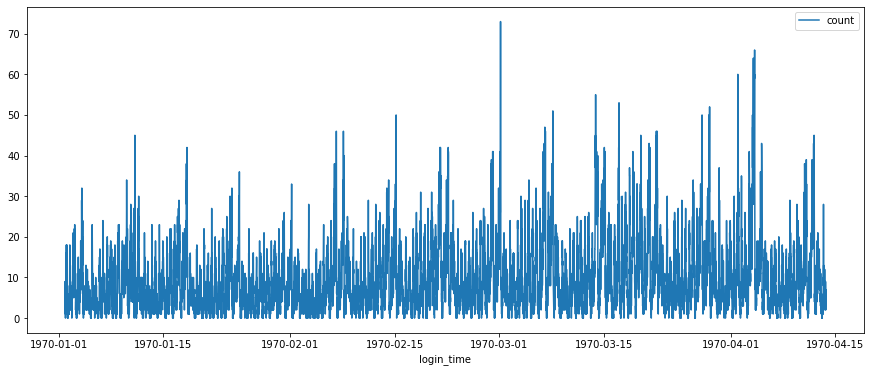

In [16]:
#Visualise the no. of login time per 15 mins interval
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(data=df_15)
plt.show()

In [17]:
y = df_15['count']


<ipython-input-18-f2685c3d150a>:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(y, freq=168)


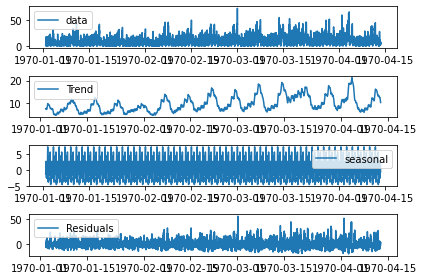

In [18]:

# Import seasonal_decompose 
from statsmodels.tsa.seasonal import seasonal_decompose

# Make a variable called decomposition, and assign it y passed to seasonal_decompose() 
decomposition = seasonal_decompose(y, freq=168) 

# Make three variables for trend, seasonal and residual components respectively. 
# Assign them the relevant features of decomposition 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.subplot(411)
plt.plot(y, label = 'data')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout() 

In [19]:
from statsmodels.tsa.stattools import kpss
result = kpss(df_15)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [20]:
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 2.989600
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


In [21]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_15)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.337954
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Question:
Ho of KPSS: Data is stationary
Ho of adfuller: Data is non-stationary
From result, we reject both.

##  Then, explore the peak and crest mean login period within a day (24 hours)

In [22]:
df_h = pd.DataFrame(df.resample('H')['count'].sum())
df_h.head()

,count
login_time,
1970-01-01 20:00:00,24
1970-01-01 21:00:00,9
1970-01-01 22:00:00,21
1970-01-01 23:00:00,58
1970-01-02 00:00:00,53


In [23]:
df_h['time'] = df_h.index.hour
df_h.head()

,count,time
login_time,,
1970-01-01 20:00:00,24,20
1970-01-01 21:00:00,9,21
1970-01-01 22:00:00,21,22
1970-01-01 23:00:00,58,23
1970-01-02 00:00:00,53,0


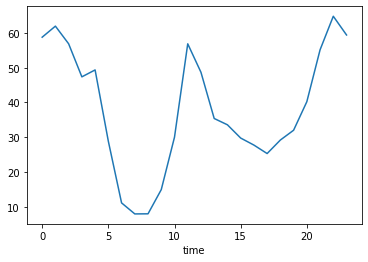

In [24]:
df_h.groupby('time')['count'].mean().plot()
plt.show()

In [25]:
df_hm = df_h.groupby('time')['count'].mean()

print(df_hm)

time
0     58.754902
1     61.931373
2     56.862745
3     47.362745
4     49.352941
5     28.872549
6     11.156863
7      7.990196
8      8.019608
9     14.970588
10    30.039216
11    56.852941
12    48.666667
13    35.401961
14    33.588235
15    29.784314
16    27.764706
17    25.333333
18    29.215686
19    32.029703
20    40.225490
21    55.127451
22    64.774510
23    59.392157
Name: count, dtype: float64


From above plot,we can observe:

1)There are 2 login peak periods.

2)The largest peak is in evening. It starts from 18:00 and peaks at 21:00, then dissipate and reach minimum at 7:00 of next morning.

3)The second peak is in morning. It starts from minimum at 7:00 to 11:00, then dissipate during the lunch hour.

##  Then, explore the mean login in different day of week

In [26]:
df_D = pd.DataFrame(df.resample('D')['count'].sum())


In [27]:
df_D['dayOfweek']= df_D.index.weekday+1


In [28]:
df_D.head()


,count,dayOfweek
login_time,,
1970-01-01,112,4
1970-01-02,681,5
1970-01-03,793,6
1970-01-04,788,7
1970-01-05,459,1


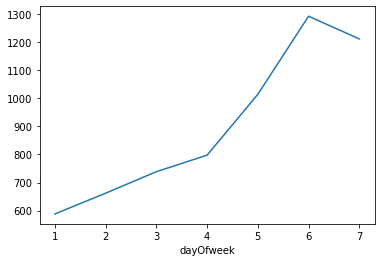

In [29]:
df_D.groupby('dayOfweek')['count'].mean().plot()
plt.show()


In [30]:
print(df_D.groupby('dayOfweek')['count'].mean())

dayOfweek
1     588.200000
2     662.000000
3     738.500000
4     797.333333
5    1013.866667
6    1291.800000
7    1211.133333
Name: count, dtype: float64


From above plot,we can obserse the mean login time increase throughout the week from Mon to Sun. The peak login volume is during the weakend (Fri to Sun). Saturday has the maximum login volume amoung all week days.

## Part 2 ‑ Experiment and metrics design


The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

1 What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

2 Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a. how you will implement the experiment

b. what statistical test(s) you will conduct to verify the significance of the observation

c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.


Ans:

1)I would use the percentage change in traffic volume of the toll bridge before and after reimbursing all toll costs. If the percentage change in significantly positive, this shows that the toll fee of the bridge is a significant barrier of people travel between two cities and vice versa.

2a)The independent factor of the experiment is reducing the toll price for a reasonable period (3 months). The dependent factor is the percentage chage in traffic volume of the toll bridge before and after reducing the toll.

2b) t-test will be adopted to verify the significance of the observation. The null hypothesis is that percentage change is close to zero. (No change in traffic volume) ant the alternative hypothesis is that the percentage change is significant.(The traffic clolume is different from before.)

One-tail t-test will be adopted as we are only interested in positive percentage change. The confidence interval will be set to 95%.


2c) Outcome 1:The null hypothesis will be rejected if the p value is less than 0.05 (for t-statistic > 95 percentile). Then we can deduce toll fee is a significant factor affecting the no. of people traveling from one city to another. In this case, we suggest the city to lower the toll fee to encourage more people to travel.

Outcome 2: The null hypothesis can not be rejected if p value is larger than 0.05 (for t-statistic < 95 percentile). Then we can deduce toll fee is a non-significant factor affecting the no. of people traveling from one city to another. In this case, we will not suggest the city to lower the toll fee to encourage more people to travel.

## Part 3 ‑ Predictive modeling


## Step1 : Data Peview & Wrangling 

In [31]:
#import data into data frame dt
dt = pd.read_json('ultimate_data_challenge.json')

In [32]:
#Data Preview
dt.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [33]:
dt.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [34]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [35]:
print(dt['last_trip_date'].max())
print(dt['last_trip_date'].min())

2014-07-01
2014-01-01


As the period is from 2014-01-01 to 2014-07-01, the active member should have last_trip_date from 2014-06-01 to 2014-07-01.


In [36]:
# dt[['signup_date', 'last_trip_date' ]] = pd.to_datetime(dt[['signup_date', 'last_trip_date' ]],format='%Y-%m-%d')

dt['signup_date'] = pd.to_datetime(dt['signup_date'])
dt['last_trip_date'] = pd.to_datetime(dt['last_trip_date'])

In [37]:
#Label All Active member as 1 and non-active member as 0
dt['active'] = np.where((dt.last_trip_date.map(lambda x: x.month)>=6),1,0)

In [38]:
retained_pct = dt.active.value_counts(normalize=True)
retained_pct

0    0.62392
1    0.37608
Name: active, dtype: float64

In [39]:
pd.DataFrame((dt.isnull().sum(),dt.dtypes), index=['missing value', 'data type']).T


,missing value,data type
city,0,object
trips_in_first_30_days,0,int64
signup_date,0,datetime64[ns]
avg_rating_of_driver,8122,float64
avg_surge,0,float64
last_trip_date,0,datetime64[ns]
phone,396,object
surge_pct,0,float64
ultimate_black_user,0,bool
weekday_pct,0,float64


In [40]:
dt['count'] = 1
dt_gpby = dt.groupby('avg_rating_of_driver')['count'].sum()

In [41]:
print(dt_gpby)

avg_rating_of_driver
1.0      256
1.5        4
1.6        1
1.7        2
1.8        2
1.9        1
2.0      209
2.1        6
2.2        1
2.3       22
2.4        3
2.5       94
2.6       12
2.7       47
2.8       28
2.9       13
3.0     1003
3.1       39
3.2       53
3.3      201
3.4      108
3.5      488
3.6      172
3.7      364
3.8      428
3.9      255
4.0     4193
4.1      398
4.2      601
4.3     1487
4.4      829
4.5     2498
4.6     1143
4.7     1945
4.8     2430
4.9     1771
5.0    20771
Name: count, dtype: int64


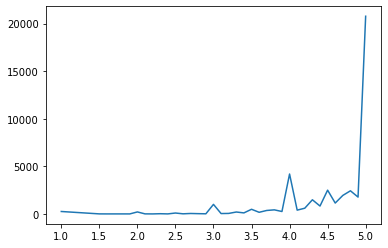

In [42]:
plt.plot(dt_gpby)

In [43]:
dt_m = dt[dt.avg_rating_of_driver.isnull()]

In [44]:
retained_pct = dt_m.active.value_counts(normalize=True)
retained_pct

0    0.799064
1    0.200936
Name: active, dtype: float64

Most Costomer with missing avg_rating_of_driver are non-active

In [45]:
bins = [0, 2, 3, 4, np.inf]
names = ['<=2', '2-3', '3-4', '4-5']

dt['avg_rating_of_driver_Range'] = pd.cut(dt['avg_rating_of_driver'], bins, labels=names)

In [46]:
dt.tail()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,count,avg_rating_of_driver_Range
49995,King's Landing,0,2014-01-25,5.0,1.0,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,1,1,4-5
49996,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0,0,1,NaN
49997,Winterfell,0,2014-01-31,5.0,1.0,2014-05-22,Android,0.0,True,100.0,3.86,5.0,0,1,4-5
49998,Astapor,2,2014-01-14,3.0,1.0,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5,0,1,2-3
49999,Astapor,0,2014-01-18,NaN,1.0,2014-04-20,Android,0.0,False,0.0,3.49,5.0,0,1,NaN


In [47]:
dt_gpby = dt.groupby('avg_rating_of_driver_Range')['count'].sum()
print(dt_gpby)

avg_rating_of_driver_Range
<=2      475
2-3     1229
3-4     6301
4-5    33873
Name: count, dtype: int64


In [48]:
dt['avg_rating_of_driver_Range'] = dt['avg_rating_of_driver_Range'].cat.add_categories('Missing')
dt['avg_rating_of_driver_Range'].fillna('Missing', inplace =True) 

In [49]:
dt[dt['avg_rating_of_driver_Range'] == 'Missing'].avg_rating_of_driver_Range.count()

8122

In [50]:
dt_gpby = dt.groupby('avg_rating_by_driver')['count'].sum()

In [51]:
print(dt_gpby)

avg_rating_by_driver
1.0      181
1.5        4
2.0      126
2.3        1
2.5       31
2.7        2
2.8        3
3.0      602
3.2        2
3.3       47
3.4        5
3.5      199
3.6       19
3.7      195
3.8      111
3.9       41
4.0     1914
4.1      125
4.2      342
4.3     1018
4.4      860
4.5     2424
4.6     2078
4.7     3330
4.8     4537
4.9     3094
5.0    28508
Name: count, dtype: int64


In [52]:
bins = [0, 2, 3, 4, np.inf]
names = ['<=2', '2-3', '3-4', '4-5']

dt['avg_rating_by_driver_Range'] = pd.cut(dt['avg_rating_by_driver'], bins, labels=names)

In [53]:
dt_gpby = dt.groupby('avg_rating_by_driver_Range')['count'].sum()
print(dt_gpby)

avg_rating_by_driver_Range
<=2      311
2-3      639
3-4     2533
4-5    46316
Name: count, dtype: int64


The remaining missing data are only very small portion compared with the data size. We can simply just drop the missing value.

In [54]:
dt.drop(columns=['count','avg_rating_by_driver','avg_rating_of_driver'],inplace = True)

In [55]:
dt.dropna(inplace = True)

In [56]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49406 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   city                        49406 non-null  object        
 1   trips_in_first_30_days      49406 non-null  int64         
 2   signup_date                 49406 non-null  datetime64[ns]
 3   avg_surge                   49406 non-null  float64       
 4   last_trip_date              49406 non-null  datetime64[ns]
 5   phone                       49406 non-null  object        
 6   surge_pct                   49406 non-null  float64       
 7   ultimate_black_user         49406 non-null  bool          
 8   weekday_pct                 49406 non-null  float64       
 9   avg_dist                    49406 non-null  float64       
 10  active                      49406 non-null  int32         
 11  avg_rating_of_driver_Range  49406 non-null  category  

## Step 2: Exploratory Data Analysis (EDA)

## Data Visualization

In [57]:
dt[['city','phone','ultimate_black_user','active']] = dt[['city','phone','ultimate_black_user','active']].astype("category")


In [58]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49406 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   city                        49406 non-null  category      
 1   trips_in_first_30_days      49406 non-null  int64         
 2   signup_date                 49406 non-null  datetime64[ns]
 3   avg_surge                   49406 non-null  float64       
 4   last_trip_date              49406 non-null  datetime64[ns]
 5   phone                       49406 non-null  category      
 6   surge_pct                   49406 non-null  float64       
 7   ultimate_black_user         49406 non-null  category      
 8   weekday_pct                 49406 non-null  float64       
 9   avg_dist                    49406 non-null  float64       
 10  active                      49406 non-null  category      
 11  avg_rating_of_driver_Range  49406 non-null  category  

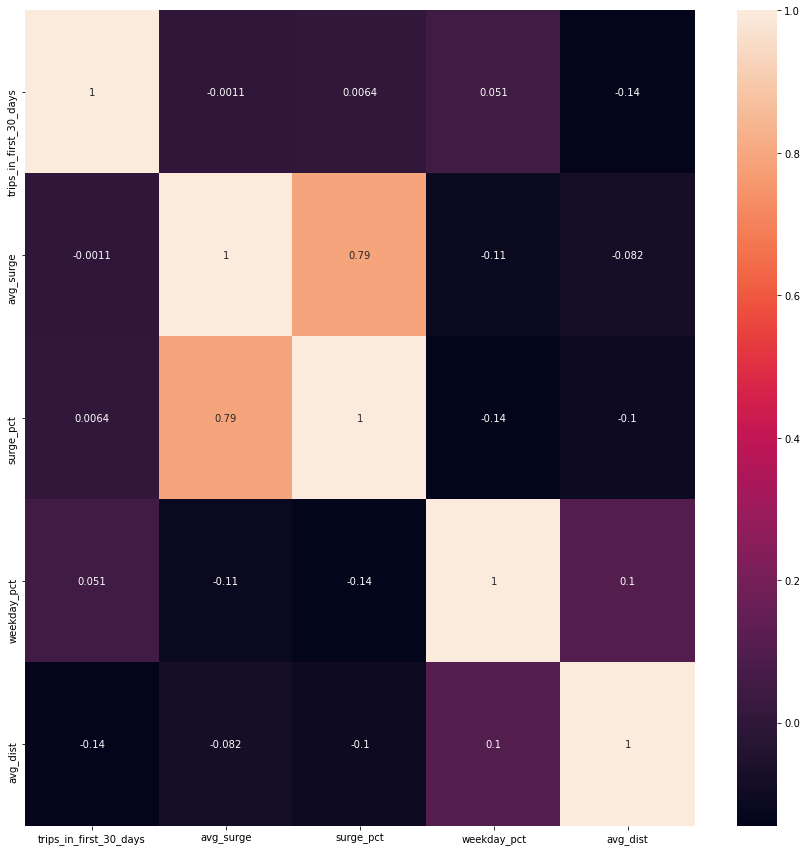

In [59]:
plt.subplots(figsize=(15,15))
sns.heatmap(dt.corr(),annot=True)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


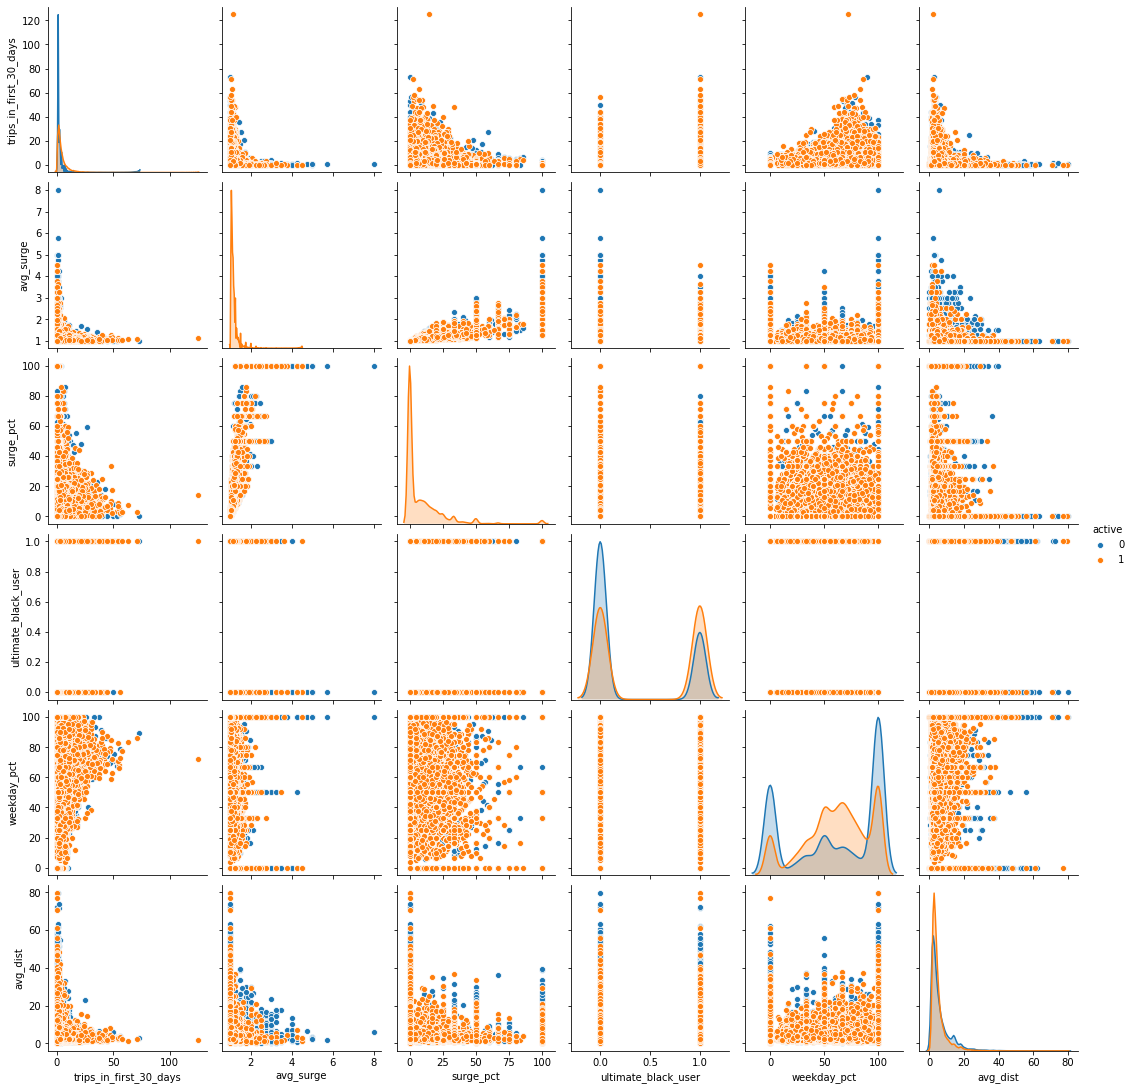

In [60]:
sns.pairplot(data=dt, hue='active')
plt.show()

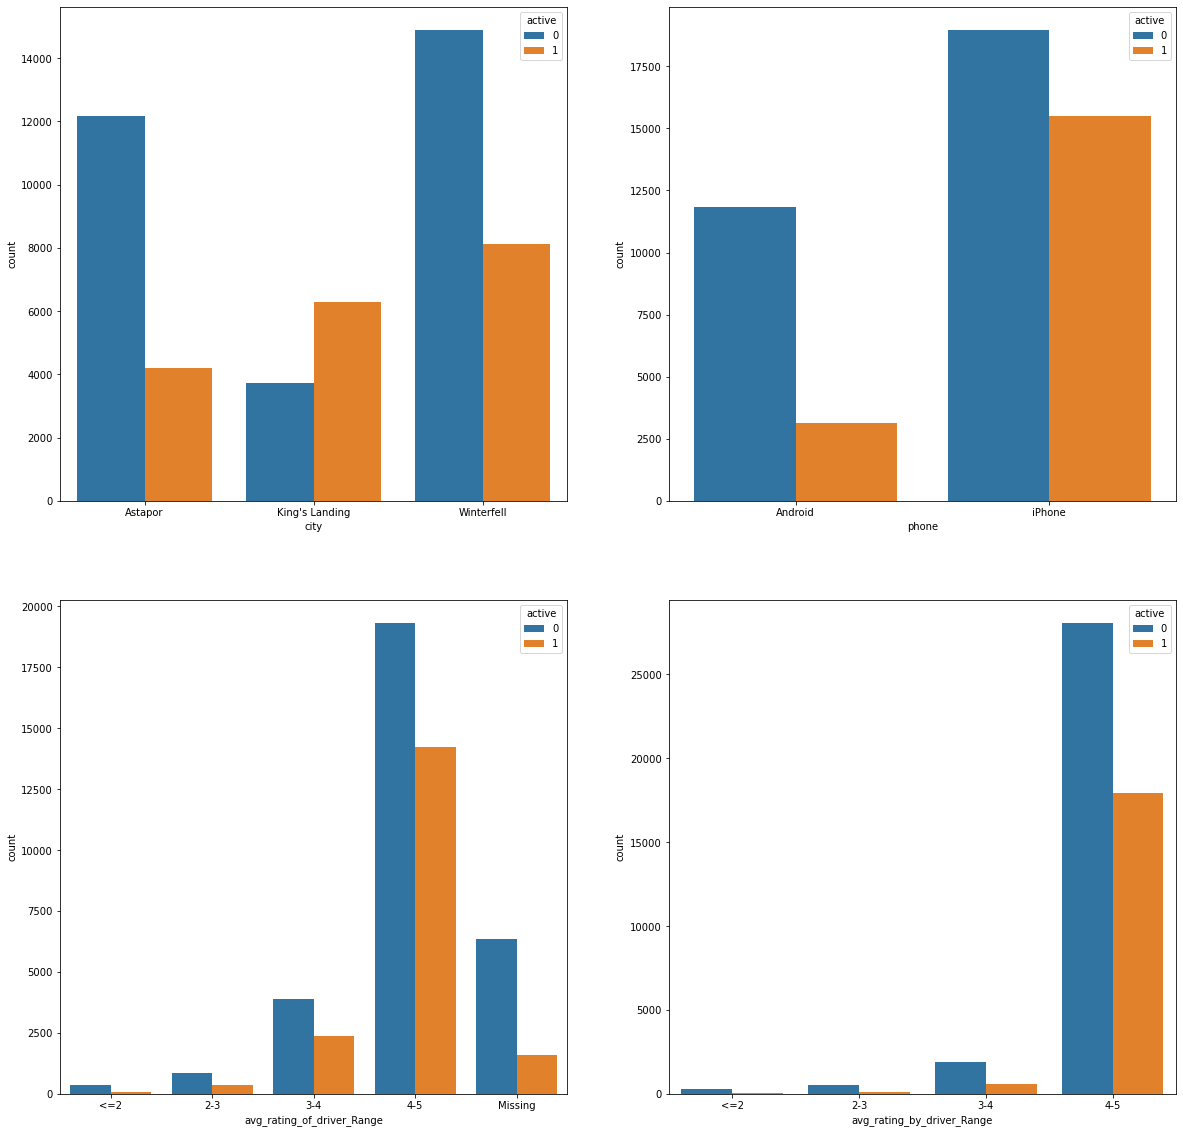

In [61]:
plt.subplots(figsize=(20, 20))
plt.subplot(2, 2, 1)

ax = sns.countplot(x="city", data=dt,hue = "active")
plt.subplot(2, 2, 2)

ax = sns.countplot(x="phone", data=dt,hue = "active")

plt.subplot(2, 2, 3)

ax = sns.countplot(x="avg_rating_of_driver_Range", data=dt,hue = "active")

plt.subplot(2, 2, 4)

ax = sns.countplot(x="avg_rating_by_driver_Range", data=dt,hue = "active")

## Chi-square test

The Chi-Square Test of Independence is commonly used to test the following: Statistical independence or association between two or more categorical variables.

In [62]:
dd = pd.get_dummies(dt.drop(columns=['active']))

In [63]:
dd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49406 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   trips_in_first_30_days              49406 non-null  int64         
 1   signup_date                         49406 non-null  datetime64[ns]
 2   avg_surge                           49406 non-null  float64       
 3   last_trip_date                      49406 non-null  datetime64[ns]
 4   surge_pct                           49406 non-null  float64       
 5   weekday_pct                         49406 non-null  float64       
 6   avg_dist                            49406 non-null  float64       
 7   city_Astapor                        49406 non-null  uint8         
 8   city_King's Landing                 49406 non-null  uint8         
 9   city_Winterfell                     49406 non-null  uint8         
 10  phone_Android         

In [64]:
for i in dd.columns[7:]:
    dd[i] = dd[i].astype("category")


In [65]:
dd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49406 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   trips_in_first_30_days              49406 non-null  int64         
 1   signup_date                         49406 non-null  datetime64[ns]
 2   avg_surge                           49406 non-null  float64       
 3   last_trip_date                      49406 non-null  datetime64[ns]
 4   surge_pct                           49406 non-null  float64       
 5   weekday_pct                         49406 non-null  float64       
 6   avg_dist                            49406 non-null  float64       
 7   city_Astapor                        49406 non-null  category      
 8   city_King's Landing                 49406 non-null  category      
 9   city_Winterfell                     49406 non-null  category      
 10  phone_Android         

In [74]:
de = pd.DataFrame()
for i in range(7,23):
    de[dd.columns[i]] = dd[dd.columns[i]]

In [75]:
de.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49406 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   city_Astapor                        49406 non-null  category
 1   city_King's Landing                 49406 non-null  category
 2   city_Winterfell                     49406 non-null  category
 3   phone_Android                       49406 non-null  category
 4   phone_iPhone                        49406 non-null  category
 5   ultimate_black_user_False           49406 non-null  category
 6   ultimate_black_user_True            49406 non-null  category
 7   avg_rating_of_driver_Range_<=2      49406 non-null  category
 8   avg_rating_of_driver_Range_2-3      49406 non-null  category
 9   avg_rating_of_driver_Range_3-4      49406 non-null  category
 10  avg_rating_of_driver_Range_4-5      49406 non-null  category
 11  avg_rating_of_driver_Range_M

avg_rating_by_driver_Range_4-5        1.073235e-04
avg_rating_by_driver_Range_<=2        1.338156e-06
avg_rating_of_driver_Range_<=2        1.210529e-07
avg_rating_by_driver_Range_2-3        8.928085e-12
phone_iPhone                          2.215288e-12
avg_rating_of_driver_Range_2-3        4.506494e-13
ultimate_black_user_False             1.977818e-13
ultimate_black_user_True              8.343301e-22
avg_rating_of_driver_Range_Missing    1.568560e-23
phone_Android                         1.461792e-27
avg_rating_of_driver_Range_4-5        5.498406e-35
avg_rating_by_driver_Range_3-4        9.262097e-37
avg_rating_of_driver_Range_3-4        4.697521e-48
dtype: float64


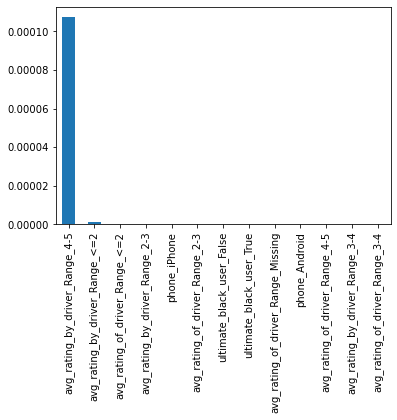

In [82]:
#chi square for checking correlation between categorical features - smoker
a = pd.DataFrame()
for i in range(3,16):
    a[de.columns[i]] = de[de.columns[i]]

b = dt.city
chi_scores = chi2(a,b)

chi_scores
p_values = pd.Series(chi_scores[1],index = a.columns)
p_values.sort_values(ascending = False , inplace = True)
print(p_values)

p_values.plot.bar()


avg_rating_of_driver_Range_2-3        7.727551e-01
avg_rating_of_driver_Range_<=2        6.491938e-01
avg_rating_by_driver_Range_4-5        1.180801e-01
avg_rating_by_driver_Range_2-3        1.025206e-02
avg_rating_by_driver_Range_<=2        8.993713e-03
avg_rating_of_driver_Range_4-5        5.056434e-04
city_Winterfell                       9.910724e-05
avg_rating_by_driver_Range_3-4        7.644875e-06
city_Astapor                          3.180361e-06
avg_rating_of_driver_Range_3-4        1.900604e-06
ultimate_black_user_False             1.052350e-23
avg_rating_of_driver_Range_Missing    8.607620e-29
city_King's Landing                   2.183714e-32
ultimate_black_user_True              3.116541e-38
dtype: float64


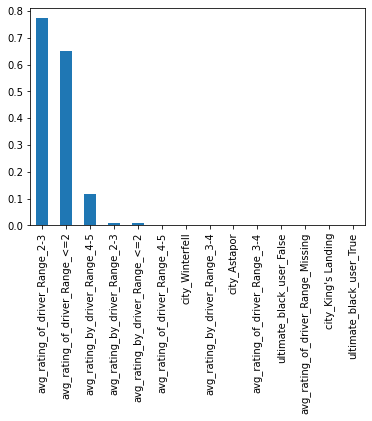

In [84]:
#chi square for checking correlation between categorical features - smoker

a1 = de.drop(columns = ['phone_iPhone','phone_Android'])
b = dt.phone
chi_scores = chi2(a1,b)

chi_scores
p_values = pd.Series(chi_scores[1],index = a1.columns)
p_values.sort_values(ascending = False , inplace = True)
print(p_values)

p_values.plot.bar()


avg_rating_of_driver_Range_3-4        2.354459e-01
avg_rating_of_driver_Range_2-3        8.504391e-02
avg_rating_by_driver_Range_4-5        7.340466e-03
avg_rating_of_driver_Range_<=2        1.330687e-03
city_Astapor                          6.353780e-05
avg_rating_by_driver_Range_<=2        1.089531e-06
avg_rating_of_driver_Range_4-5        6.379331e-07
avg_rating_by_driver_Range_3-4        1.730900e-10
avg_rating_by_driver_Range_2-3        2.074949e-11
avg_rating_of_driver_Range_Missing    1.151059e-14
city_King's Landing                   9.944740e-16
city_Winterfell                       4.388260e-18
phone_iPhone                          2.133269e-19
phone_Android                         1.618100e-42
dtype: float64


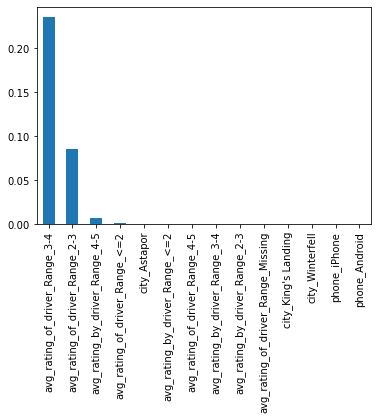

In [88]:
#chi square for checking correlation between categorical features - smoker

a1 = de.drop(columns = ['ultimate_black_user_False','ultimate_black_user_True'])
b = dt['ultimate_black_user'].map({True:'1',False:'0'}).astype("category")

chi_scores = chi2(a1,b)

chi_scores
p_values = pd.Series(chi_scores[1],index = a1.columns)
p_values.sort_values(ascending = False , inplace = True)
print(p_values)

p_values.plot.bar()


city_Astapor                          3.863618e-06
ultimate_black_user_False             1.591426e-07
phone_iPhone                          8.759181e-10
avg_rating_by_driver_Range_4-5        5.483406e-11
ultimate_black_user_True              1.198994e-12
phone_Android                         4.724200e-23
city_Winterfell                       9.079624e-37
avg_rating_by_driver_Range_2-3        1.555731e-60
avg_rating_by_driver_Range_3-4        8.018958e-62
city_King's Landing                   1.657809e-77
avg_rating_by_driver_Range_<=2        1.931252e-80
avg_rating_of_driver_Range_Missing    0.000000e+00
dtype: float64


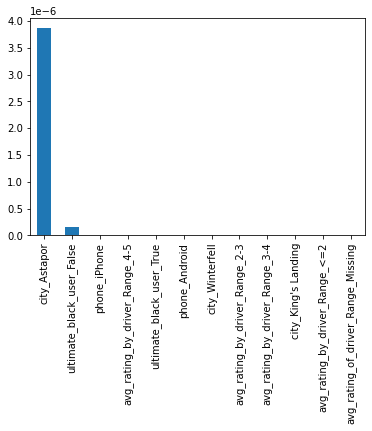

In [91]:
#chi square for checking correlation between categorical features - smoker

a2 = de.drop(columns = ['avg_rating_of_driver_Range_2-3','avg_rating_of_driver_Range_<=2','avg_rating_of_driver_Range_4-5','avg_rating_of_driver_Range_3-4'])
b = dt['avg_rating_of_driver_Range']

chi_scores = chi2(a2,b)

chi_scores
p_values = pd.Series(chi_scores[1],index = a2.columns)
p_values.sort_values(ascending = False , inplace = True)
print(p_values)

p_values.plot.bar()


city_Astapor                          3.863618e-06
ultimate_black_user_False             1.591426e-07
phone_iPhone                          8.759181e-10
ultimate_black_user_True              1.198994e-12
phone_Android                         4.724200e-23
city_Winterfell                       9.079624e-37
city_King's Landing                   1.657809e-77
avg_rating_of_driver_Range_Missing    0.000000e+00
avg_rating_of_driver_Range_4-5        0.000000e+00
avg_rating_of_driver_Range_3-4        0.000000e+00
avg_rating_of_driver_Range_2-3        0.000000e+00
avg_rating_of_driver_Range_<=2        0.000000e+00
dtype: float64


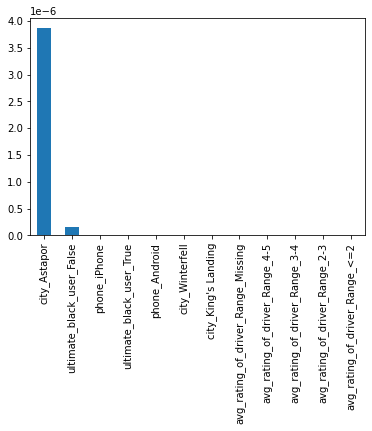

In [92]:
#chi square for checking correlation between categorical features - smoker

a3 = de.drop(columns = ['avg_rating_by_driver_Range_2-3','avg_rating_by_driver_Range_<=2','avg_rating_by_driver_Range_4-5','avg_rating_by_driver_Range_3-4'])
b = dt['avg_rating_of_driver_Range']

chi_scores = chi2(a3,b)

chi_scores
p_values = pd.Series(chi_scores[1],index = a3.columns)
p_values.sort_values(ascending = False , inplace = True)
print(p_values)

p_values.plot.bar()


In 95 %confidence interval, most features are independent with each other except

1) Phone maybe correlated with the average rating of driver (rating above 2)

2) ultimate_black_user maybe correlated with the average rating of driver (rating between 2-4)

Caution shakk be paid to these factors in the next stage





## Modelling

In [93]:
dd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49406 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   trips_in_first_30_days              49406 non-null  int64         
 1   signup_date                         49406 non-null  datetime64[ns]
 2   avg_surge                           49406 non-null  float64       
 3   last_trip_date                      49406 non-null  datetime64[ns]
 4   surge_pct                           49406 non-null  float64       
 5   weekday_pct                         49406 non-null  float64       
 6   avg_dist                            49406 non-null  float64       
 7   city_Astapor                        49406 non-null  category      
 8   city_King's Landing                 49406 non-null  category      
 9   city_Winterfell                     49406 non-null  category      
 10  phone_Android         

In [96]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(dd[['trips_in_first_30_days','avg_surge','surge_pct','weekday_pct','avg_dist']])
dd_scaled = dd[['trips_in_first_30_days','avg_surge','surge_pct','weekday_pct','avg_dist']]
dd_scaled[['trips_in_first_30_days','avg_surge','surge_pct','weekday_pct','avg_dist']] = scaler.transform(dd[['trips_in_first_30_days','avg_surge','surge_pct','weekday_pct','avg_dist']])

<ipython-input-96-5fc5b3f109f5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd_scaled[['trips_in_first_30_days','avg_surge','surge_pct','weekday_pct','avg_dist']] = scaler.transform(dd[['trips_in_first_30_days','avg_surge','surge_pct','weekday_pct','avg_dist']])
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [97]:
dd_scaled.head()

,trips_in_first_30_days,avg_surge,surge_pct,weekday_pct,avg_dist
0,0.451637,0.114853,0.329473,-0.397411,-0.375668
1,-0.601237,-0.337622,-0.444787,-0.294772,0.440002
2,0.188418,-0.337622,-0.444787,1.055747,-0.891016
3,1.767729,0.295844,0.560746,0.515540,-0.608463
4,3.083822,0.522081,0.148477,0.580365,-0.471629


In [99]:
dd_scaled_r =  dd.drop(['trips_in_first_30_days','avg_surge','surge_pct','weekday_pct','avg_dist'],axis = 1)

In [102]:
dd_scaled_r[['trips_in_first_30_days','avg_surge','surge_pct','weekday_pct','avg_dist']] = dd_scaled[['trips_in_first_30_days','avg_surge','surge_pct','weekday_pct','avg_dist']]
dd_scaled_r.head()

,signup_date,last_trip_date,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True,avg_rating_of_driver_Range_<=2,...,avg_rating_of_driver_Range_Missing,avg_rating_by_driver_Range_<=2,avg_rating_by_driver_Range_2-3,avg_rating_by_driver_Range_3-4,avg_rating_by_driver_Range_4-5,trips_in_first_30_days,avg_surge,surge_pct,weekday_pct,avg_dist
0,2014-01-25,2014-06-17,0,1,0,0,1,0,1,0,...,0,0,0,0,1,0.451637,0.114853,0.329473,-0.397411,-0.375668
1,2014-01-29,2014-05-05,1,0,0,1,0,1,0,0,...,0,0,0,0,1,-0.601237,-0.337622,-0.444787,-0.294772,0.440002
2,2014-01-06,2014-01-07,1,0,0,0,1,1,0,0,...,0,0,0,0,1,0.188418,-0.337622,-0.444787,1.055747,-0.891016
3,2014-01-10,2014-06-29,0,1,0,0,1,0,1,0,...,0,0,0,0,1,1.767729,0.295844,0.560746,0.515540,-0.608463
4,2014-01-27,2014-03-15,0,0,1,1,0,1,0,0,...,0,0,0,0,1,3.083822,0.522081,0.148477,0.580365,-0.471629


In [104]:
dd_scaled_r.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49406 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   signup_date                         49406 non-null  datetime64[ns]
 1   last_trip_date                      49406 non-null  datetime64[ns]
 2   city_Astapor                        49406 non-null  category      
 3   city_King's Landing                 49406 non-null  category      
 4   city_Winterfell                     49406 non-null  category      
 5   phone_Android                       49406 non-null  category      
 6   phone_iPhone                        49406 non-null  category      
 7   ultimate_black_user_False           49406 non-null  category      
 8   ultimate_black_user_True            49406 non-null  category      
 9   avg_rating_of_driver_Range_<=2      49406 non-null  category      
 10  avg_rating_of_driver_R

In [112]:
X_train, X_test, y_train, y_test = train_test_split(dd_scaled_r.drop(columns=['signup_date','last_trip_date']),
                                                    dt.active, test_size=0.3, 
                                                    random_state=47)

In [106]:
print(X_test)

      signup_date last_trip_date city_Astapor city_King's Landing  \
46750  2014-01-25     2014-04-25            0                   1   
25401  2014-01-26     2014-03-29            0                   1   
28171  2014-01-11     2014-06-14            0                   1   
24338  2014-01-23     2014-02-28            0                   1   
12242  2014-01-16     2014-06-14            0                   0   
...           ...            ...          ...                 ...   
48823  2014-01-11     2014-02-15            1                   0   
12253  2014-01-22     2014-06-29            0                   0   
21064  2014-01-08     2014-04-10            1                   0   
8300   2014-01-14     2014-04-03            0                   0   
11962  2014-01-23     2014-06-07            0                   1   

      city_Winterfell phone_Android phone_iPhone ultimate_black_user_False  \
46750               0             1            0                         1   
25401          

In [107]:
print(y_train)

30624    1
3169     0
35330    1
18399    1
26267    0
        ..
25556    1
23379    1
11656    1
47996    1
38466    1
Name: active, Length: 34584, dtype: category
Categories (2, int64): [0, 1]


In [113]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold


rfc = RandomForestClassifier(random_state = 10)
rfecv = RFECV(estimator = rfc,step = 1, cv = StratifiedKFold(10),scoring ='accuracy')
rfecv.fit(X_train,y_train)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(random_state=10), scoring='accuracy')

In [114]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 16


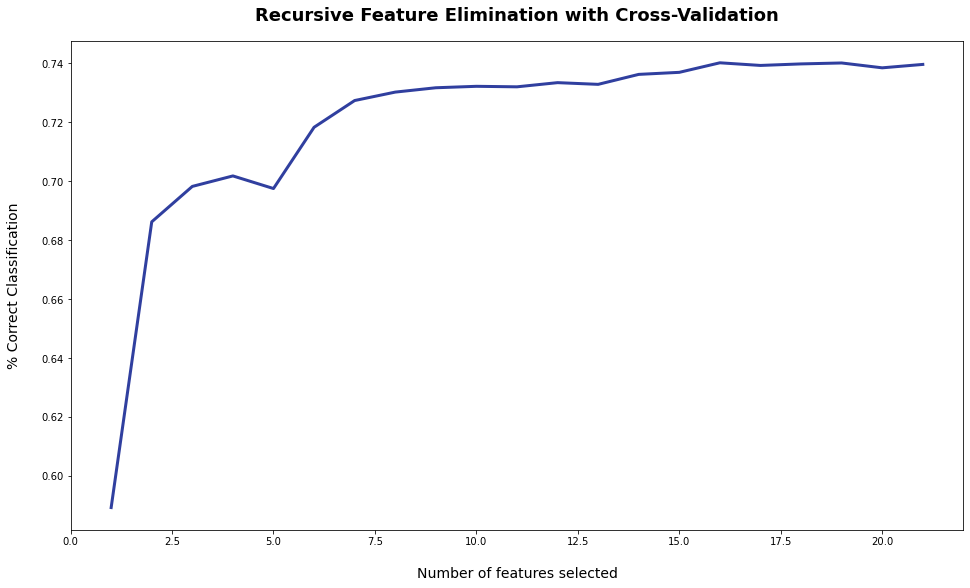

In [115]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
plt.show()

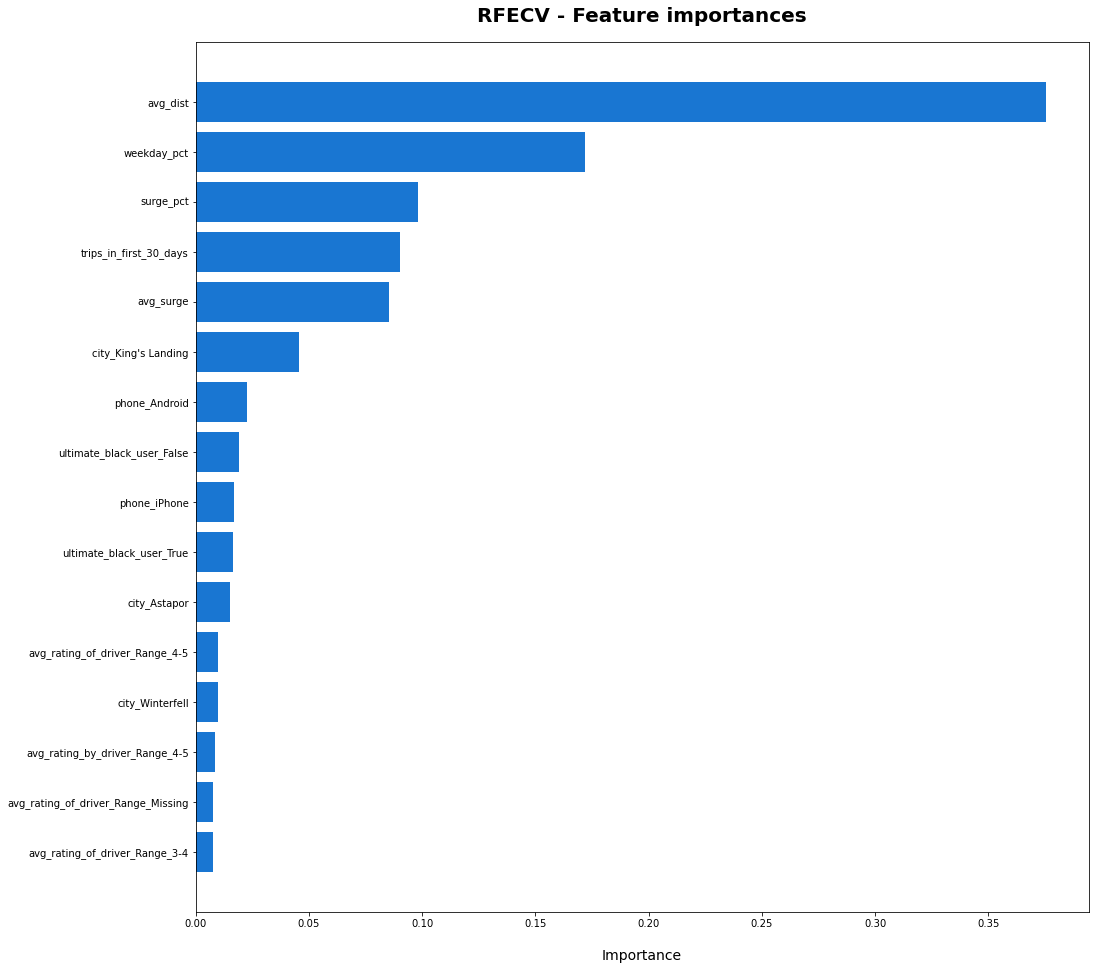

In [157]:
dset = pd.DataFrame()
dset['attr'] = X_train.columns[rfecv.support_]
dset['importance'] = rfecv.estimator_.feature_importances_
dset = dset.sort_values(by='importance', ascending=True)

plt.figure(figsize=(16, 16))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [137]:
print(X_train.columns[7])
print(X_train.columns[8])
print(X_train.columns[12])
print(X_train.columns[13])
print(X_train.columns[14])


avg_rating_of_driver_Range_<=2
avg_rating_of_driver_Range_2-3
avg_rating_by_driver_Range_<=2
avg_rating_by_driver_Range_2-3
avg_rating_by_driver_Range_3-4


The above features are filtered out

In [139]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train,y_train)

RandomForestClassifier()

In [143]:
model.score(X_train,y_train)

0.9954603284755956

In [140]:
model.score(X_test,y_test)

0.7381594926460666

In [141]:
y_pred = model.predict(X_test)

In [124]:
model.score(X_test,y_test)

array([0.01512894, 0.04539603, 0.00974268, 0.02252256, 0.01690935,
       0.01912471, 0.01649754, 0.00759198, 0.00995575, 0.00765912,
       0.00851727, 0.0904265 , 0.08515262, 0.09807331, 0.17186849,
       0.37543317])

In [155]:
from sklearn.metrics import confusion_matrix,classification_report
cm =confusion_matrix(y_test,y_pred)
cm

array([[7343, 1839],
       [2042, 3598]], dtype=int64)

Text(69.0, 0.5, 'True')

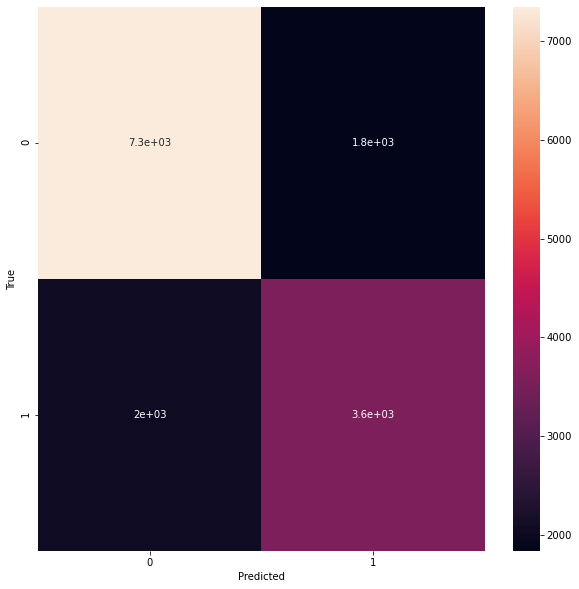

In [152]:
plt.figure(figsize=(10,10))
sns.heatmap(cm,annot = True)
plt.xlabel('Predicted')
plt.ylabel('True')

In [156]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.78      0.80      0.79      9182
           1       0.66      0.64      0.65      5640

    accuracy                           0.74     14822
   macro avg       0.72      0.72      0.72     14822
weighted avg       0.74      0.74      0.74     14822



Model tends to overestimate the non-active and lowerestimate the active.

## Q & A

Q1)  Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?


49406/50000 (98.8%) data are retained

Q2) Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?

Radom Forest Classifer - The logic is simple and the process is more transparent. Customer can easily understand the model. The comparison of features importance is easy to understand. When one-hot encoding is applied, we can further compare the items of each category such as cities, the rating point and phne types.

Q3) Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).


According to our  model, factors that are best predictors for retention are avg_dist, weekday_pct,surge_pct ,trips_in_first_30_days. (Top 4 features)



As the customers who used more in the weekday are higher potential to be active. Ultimate can provide more riding and service to facilate weekday users. The may probably use Ultimate for going and leaving office.

Ultimate can focus on the customers who have higher miles per trip in the first 30 days.